In [160]:
from IPython.display import HTML
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, LinearSVR
import matplotlib.pyplot as plt
from pydfs_lineup_optimizer import get_optimizer, Site, Sport

In [161]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [162]:
file = r'C:\Users\stang\Google Drive\Data_for_fun\Fantasy Basketball\FanDuel\FanDuel-NBA-2019-01-09-31836-players-list.csv'

In [163]:
gamelogs_17 = pd.read_csv(r'C:\Users\stang\Google Drive\Data_for_fun\Fantasy Basketball\2017_18_NBA_Stats.csv')
gamelogs_17.drop(columns=['ID'], inplace=True)
gamelogs_17['BLK'].fillna(0, inplace=True)
gamelogs_17 = gamelogs_17[gamelogs_17['MP'] > 0]

In [164]:
gamelogs_18 = pd.read_csv(r'C:\Users\stang\Google Drive\Data_for_fun\Fantasy Basketball\GameLogs.csv')
gamelogs_18.drop(columns=['Unnamed: 0'], inplace=True)
gamelogs_18.rename(columns={'Unnamed: 6':'Home/Away', 'Unnamed: 8':'Result'}, inplace=True)
gamelogs_18 = gamelogs_18[gamelogs_18['MP'] > 0]

## Feature Engineering

#### General Cleanup

In [165]:
gamelogs_17.drop(columns=['Rk', 'Result', '2P', '2PA', '2P%', '3P', '3PA', '3P%', 'PF', 'FT%', 'FG%', 
                       'FG', 'FGA', 'FT', 'FTA', 'ORB', 'DRB','GmSc'], inplace=True)
gamelogs_18.drop(columns=['Rk', 'Result', '2P', '2PA', '2P%', '3P', '3PA', '3P%', 'PF', 'FT%', 'FG%', 
                       'FG', 'FGA', 'FT', 'FTA', 'ORB', 'DRB','GmSc'], inplace=True)

In [166]:
gamelogs_17['Season'] = '17/18'
gamelogs_18['Season'] = '18/19'

In [167]:
gamelogs_17['FPTS'] = gamelogs_17.TRB*1.2 + gamelogs_17.AST*1.5 + gamelogs_17.STL*3 + gamelogs_17.BLK*3 - gamelogs_17.TOV + \
                    gamelogs_17.PTS
gamelogs_18['FPTS'] = gamelogs_18.TRB*1.2 + gamelogs_18.AST*1.5 + gamelogs_18.STL*3 + gamelogs_18.BLK*3 - gamelogs_18.TOV + \
                    gamelogs_18.PTS

In [168]:
gamelogs_17.drop_duplicates(keep='first', inplace=True)
gamelogs_18.drop_duplicates(keep='first', inplace=True)

#### Game Number

In [169]:
gamelogs_17['Date'] = pd.to_datetime(gamelogs_17['Date'])
gamelogs_17['Game_Num'] = gamelogs_17.sort_values(by=['Player','Date']).groupby('Player').cumcount() + 1

In [170]:
gamelogs_18['Date'] = pd.to_datetime(gamelogs_18['Date'])
gamelogs_18['Game_Num'] = gamelogs_18.sort_values(by=['Player','Date']).groupby('Player').cumcount() + 1

#### Previous Game Variables (Fantasy Points, Minutes Played, Start)

In [171]:
gamelogs_17['PV_MP'] = gamelogs_17.sort_values(['Player','Date']).groupby('Player')['MP'].shift(1)
gamelogs_17['PV_FPTS'] = gamelogs_17.sort_values(['Player','Date']).groupby('Player')['FPTS'].shift(1)
gamelogs_17['PV_GS'] = gamelogs_17.sort_values(['Player','Date']).groupby('Player')['GS'].shift(1)


gamelogs_17['PV_MP_2'] = gamelogs_17.sort_values(['Player','Date']).groupby('Player')['MP'].shift(2)
gamelogs_17['PV_FPTS_2'] = gamelogs_17.sort_values(['Player','Date']).groupby('Player')['FPTS'].shift(2)

In [172]:
gamelogs_18['PV_MP'] = gamelogs_18.sort_values(['Player','Date']).groupby('Player')['MP'].shift(1)
gamelogs_18['PV_FPTS'] = gamelogs_18.sort_values(['Player','Date']).groupby('Player')['FPTS'].shift(1)
gamelogs_18['PV_GS'] = gamelogs_18.sort_values(['Player','Date']).groupby('Player')['GS'].shift(1)


gamelogs_18['PV_MP_2'] = gamelogs_18.sort_values(['Player','Date']).groupby('Player')['MP'].shift(2)
gamelogs_18['PV_FPTS_2'] = gamelogs_18.sort_values(['Player','Date']).groupby('Player')['FPTS'].shift(2)

#### Season Averages - Rolling Average (Fantasy Points, Minutes Played)

In [173]:
gamelogs_17['AVG_FPTS'] = gamelogs_17.sort_values(by=['Player','Date']).groupby('Player')['PV_FPTS'] \
                            .transform(lambda x: x.expanding().mean())
gamelogs_17['Std_FPTS'] = gamelogs_17.sort_values(by=['Player','Date']).groupby('Player')['PV_FPTS'] \
                            .transform(lambda x: x.expanding().std())
gamelogs_17['AVG_MP'] = gamelogs_17.sort_values(by=['Player','Date']).groupby('Player')['PV_MP'] \
                            .transform(lambda x: x.expanding().mean())

In [174]:
gamelogs_18['AVG_FPTS'] = gamelogs_18.sort_values(by=['Player','Date']).groupby('Player')['PV_FPTS'] \
                            .transform(lambda x: x.expanding().mean())
gamelogs_18['Std_FPTS'] = gamelogs_18.sort_values(by=['Player','Date']).groupby('Player')['PV_FPTS'] \
                            .transform(lambda x: x.expanding().std())
gamelogs_18['AVG_MP'] = gamelogs_18.sort_values(by=['Player','Date']).groupby('Player')['PV_MP'] \
                            .transform(lambda x: x.expanding().mean())

#### Last 3 Games Played (Fantasy Points, Minutes Played)

In [175]:
gamelogs_17['AVG_FPTS_3'] = gamelogs_17.sort_values(by=['Player','Date']).groupby('Player')['PV_FPTS'] \
                            .rolling(3).mean().reset_index(0,drop=True)
gamelogs_17['Std_FPTS_3'] = gamelogs_17.sort_values(by=['Player','Date']).groupby('Player')['PV_FPTS'] \
                            .rolling(3).std().reset_index(0,drop=True)
gamelogs_17['AVG_MP_3'] = gamelogs_17.sort_values(by=['Player','Date']).groupby('Player')['PV_MP'] \
                            .rolling(3).mean().reset_index(0,drop=True)

In [176]:
gamelogs_18['AVG_FPTS_3'] = gamelogs_18.sort_values(by=['Player','Date']).groupby('Player')['PV_FPTS'] \
                            .rolling(3).mean().reset_index(0,drop=True)
gamelogs_18['Std_FPTS_3'] = gamelogs_18.sort_values(by=['Player','Date']).groupby('Player')['PV_FPTS'] \
                            .rolling(3).std().reset_index(0,drop=True)
gamelogs_18['AVG_MP_3'] = gamelogs_18.sort_values(by=['Player','Date']).groupby('Player')['PV_MP'] \
                            .rolling(3).mean().reset_index(0,drop=True)

#### Last 2 Games Played (Fantasy Points, Minutes Played)

In [177]:
gamelogs_17['AVG_FPTS_2'] = gamelogs_17.sort_values(by=['Player','Date']).groupby('Player')['PV_FPTS'] \
                            .rolling(2).mean().reset_index(0,drop=True)
gamelogs_17['Std_FPTS_2'] = gamelogs_17.sort_values(by=['Player','Date']).groupby('Player')['PV_FPTS'] \
                            .rolling(2).std().reset_index(0,drop=True)
gamelogs_17['AVG_MP_2'] = gamelogs_17.sort_values(by=['Player','Date']).groupby('Player')['PV_MP'] \
                            .rolling(2).mean().reset_index(0,drop=True)

In [178]:
gamelogs_18['AVG_FPTS_2'] = gamelogs_18.sort_values(by=['Player','Date']).groupby('Player')['PV_FPTS'] \
                            .rolling(2).mean().reset_index(0,drop=True)
gamelogs_18['Std_FPTS_2'] = gamelogs_18.sort_values(by=['Player','Date']).groupby('Player')['PV_FPTS'] \
                            .rolling(2).std().reset_index(0,drop=True)
gamelogs_18['AVG_MP_2'] = gamelogs_18.sort_values(by=['Player','Date']).groupby('Player')['PV_MP'] \
                            .rolling(2).mean().reset_index(0,drop=True)

#### Position (Average, Standard Deviation)

In [179]:
gamelogs_17 = gamelogs_17[~gamelogs_17['Pos'].isnull()]
gamelogs_18 = gamelogs_18[~gamelogs_18['Pos'].isnull()]

In [180]:
pos_17 = gamelogs_17.loc[:,['Pos', 'Date', 'FPTS']]
pos_17 = pos_17.groupby(['Pos', 'Date']).median()['FPTS'].reset_index()
pos_17['PV_FPTS'] = pos_17.sort_values(['Pos','Date']).groupby('Pos')['FPTS'].shift(1)
pos_17['POS_AVG_FPTS'] = pos_17.sort_values(by=['Pos','Date']).groupby('Pos')['PV_FPTS'] \
                            .transform(lambda x: x.expanding().mean())
pos_17.drop(columns=['FPTS', 'PV_FPTS'], inplace=True)

In [181]:
pos_17 = gamelogs_17.loc[:,['Pos', 'Date', 'FPTS']]
pos_17 = pos_17.groupby(['Pos', 'Date']).median()['FPTS'].reset_index()
pos_17['PV_FPTS'] = pos_17.sort_values(['Pos','Date']).groupby('Pos')['FPTS'].shift(1)
pos_17['POS_AVG_FPTS'] = pos_17.sort_values(by=['Pos','Date']).groupby('Pos')['PV_FPTS'] \
                            .transform(lambda x: x.expanding().mean())
pos_17.drop(columns=['FPTS', 'PV_FPTS'], inplace=True)

In [182]:
gamelogs_17v = pd.merge(gamelogs_17, pos_17, how='left', on=['Pos', 'Date'])
gamelogs_17 = gamelogs_17v

In [183]:
pos_18 = gamelogs_18.loc[:,['Pos', 'Date', 'FPTS']]
pos_18 = pos_18.groupby(['Pos', 'Date']).median()['FPTS'].reset_index()
pos_18['PV_FPTS'] = pos_18.sort_values(['Pos','Date']).groupby('Pos')['FPTS'].shift(1)
pos_18['POS_AVG_FPTS'] = pos_18.sort_values(by=['Pos','Date']).groupby('Pos')['PV_FPTS'] \
                            .transform(lambda x: x.expanding().mean())
pos_18.drop(columns=['FPTS', 'PV_FPTS'], inplace=True)

In [184]:
gamelogs_18v = pd.merge(gamelogs_18, pos_18, how='left', on=['Pos', 'Date'])
gamelogs_18 = gamelogs_18v

#### Opponent Season Fantasy Points Allowed by Position

In [185]:
opp_17 = gamelogs_17.loc[:,['Opp', 'Pos', 'Date', 'FPTS']]
opp_17 = opp_17.groupby(['Opp', 'Pos', 'Date']).median()['FPTS'].reset_index()
opp_17['PV_FPTS'] = opp_17.sort_values(['Opp', 'Pos','Date']).groupby(['Opp', 'Pos'])['FPTS'].shift(1)
opp_17['Opp_AVG_FPTS'] = opp_17.sort_values(by=['Opp', 'Pos','Date']).groupby(['Opp', 'Pos'])['PV_FPTS'] \
                            .transform(lambda x: x.expanding().mean())
opp_17.drop(columns=['FPTS', 'PV_FPTS'], inplace=True)

In [186]:
gamelogs_17x = pd.merge(gamelogs_17, opp_17, how='left', on=['Opp', 'Pos', 'Date'])
gamelogs_17 = gamelogs_17x

In [187]:
opp_18 = gamelogs_18.loc[:,['Opp', 'Pos', 'Date', 'FPTS']]
opp_18 = opp_18.groupby(['Opp', 'Pos', 'Date']).median()['FPTS'].reset_index()
opp_18['PV_FPTS'] = opp_18.sort_values(['Opp', 'Pos','Date']).groupby(['Opp', 'Pos'])['FPTS'].shift(1)
opp_18['Opp_AVG_FPTS'] = opp_18.sort_values(by=['Opp', 'Pos','Date']).groupby(['Opp', 'Pos'])['PV_FPTS'] \
                            .transform(lambda x: x.expanding().mean())
opp_18.drop(columns=['FPTS', 'PV_FPTS'], inplace=True)

In [188]:
gamelogs_18x = pd.merge(gamelogs_18, opp_18, how='left', on=['Opp', 'Pos', 'Date'])
gamelogs_18 = gamelogs_18x

#### Days of Rest

In [189]:
gamelogs_17['Rest'] = gamelogs_17.sort_values(['Player','Date']).groupby('Player')['Date'].diff().shift(-1).dt.days - 1
# All Star Break
gamelogs_17['Rest'] = np.where((gamelogs_17['Rest'] > 6) & 
                               ((gamelogs_17['Date'] < '2018-02-16') | (gamelogs_17['Date'] > '2018-02-22')), 
                                                        np.NaN, gamelogs_17['Rest'])
latest_17 = gamelogs_17.loc[gamelogs_17.groupby('Player').Date.idxmax()]
gamelogs_17 = pd.concat([gamelogs_17, latest_17], ignore_index=True)
gamelogs_17.drop_duplicates(keep=False, inplace=True)
gamelogs_17['Rest'].fillna((gamelogs_17['Rest'].mean()), inplace=True)
gamelogs_17 = pd.concat([gamelogs_17, latest_17], ignore_index=True)

In [190]:
gamelogs_18['Rest'] = gamelogs_18.sort_values(['Player','Date']).groupby('Player')['Date'].diff().shift(-1).dt.days - 1
# All Star Break
gamelogs_18['Rest'] = np.where((gamelogs_18['Rest'] > 6) & 
                               ((gamelogs_18['Date'] < '2019-02-15') | (gamelogs_18['Date'] > '2019-02-23')), 
                                                        np.NaN, gamelogs_18['Rest'])
latest_18 = gamelogs_18.loc[gamelogs_18.groupby('Player').Date.idxmax()]
gamelogs_18 = pd.concat([gamelogs_18, latest_18], ignore_index=True)
gamelogs_18.drop_duplicates(keep=False, inplace=True)
gamelogs_18['Rest'].fillna((gamelogs_18['Rest'].mean()), inplace=True)
gamelogs_18 = pd.concat([gamelogs_18, latest_18], ignore_index=True)

#### Injury Status

In [191]:
gamelogs_17['After_Injury'] = np.where(round(gamelogs_17['Rest'], 5) == round(gamelogs_17['Rest'].mean(), 5), 1, 0)

In [192]:
gamelogs_18['After_Injury'] = np.where(round(gamelogs_18['Rest'], 5) == round(gamelogs_17['Rest'].mean(), 5), 1, 0)

#### Concatenate Seasons Together

In [193]:
gamelogs = pd.concat([gamelogs_17, gamelogs_18], ignore_index=True)

#### Age

In [194]:
new = gamelogs['Age'].str.split("-", n = 1, expand = True) 

In [195]:
gamelogs['Years'] = new[0].astype(float)
gamelogs['Days'] = new[1].astype(float)
gamelogs['Age'] = gamelogs['Years'] + gamelogs['Days']/365
gamelogs.drop(columns=['Years', 'Days'], inplace=True)

In [196]:
gamelogs['Age_sq'] = gamelogs['Age']**2

#### Home/Away

In [197]:
gamelogs['Home/Away'] = np.where(gamelogs['Home/Away']  == '@', 0, 1).astype(int)

#### Verification

In [198]:
gamelogs[gamelogs.Game_Num > 3].head()

,Player,Age,Pos,Date,Tm,Home/Away,Opp,GS,MP,TRB,...,Std_FPTS_3,AVG_MP_3,AVG_FPTS_2,Std_FPTS_2,AVG_MP_2,POS_AVG_FPTS,Opp_AVG_FPTS,Rest,After_Injury,Age_sq
872,Ryan Anderson,29.465753,F,2017-10-23,HOU,1,MEM,1,31,6,...,8.000208,27.333333,16.25,0.353553,24.5,17.925000,11.350000,1.0,0,868.230625
873,Giannis Antetokounmpo,22.879452,F-G,2017-10-23,MIL,1,CHO,1,39,14,...,4.252450,38.333333,67.60,2.828427,39.0,24.158333,NaN,2.0,0,523.469326
875,Trevor Ariza,32.315068,F,2017-10-23,HOU,1,MEM,1,40,5,...,11.897199,33.666667,17.85,14.778532,31.5,17.925000,11.350000,4.0,0,1044.263652
876,Luke Babbitt,28.342466,F,2017-10-23,ATL,0,MIA,0,23,1,...,4.406056,10.333333,5.80,6.222540,11.0,17.925000,26.775000,2.0,0,803.295365
878,J.J. Barea,33.326027,G,2017-10-23,DAL,1,GSW,0,26,3,...,3.073001,22.333333,28.35,2.616295,24.5,19.283333,27.116667,1.0,0,1110.624102


In [199]:
gamelogs[gamelogs['FPTS'].isnull()]

,Player,Age,Pos,Date,Tm,Home/Away,Opp,GS,MP,TRB,...,Std_FPTS_3,AVG_MP_3,AVG_FPTS_2,Std_FPTS_2,AVG_MP_2,POS_AVG_FPTS,Opp_AVG_FPTS,Rest,After_Injury,Age_sq


## Model Building

In [200]:
model = gamelogs.loc[:, ['Player', 'Date', 'Game_Num','Pos', 'GS', 'FPTS','Age', 'Age_sq','PV_FPTS', 'PV_MP','AVG_MP_2','Home/Away',
                         'PV_GS', 'AVG_FPTS', 'Std_FPTS','PV_FPTS_2','PV_MP_2','AVG_FPTS_2', 'Std_FPTS_2', 'AVG_MP',
                         'AVG_FPTS_3', 'Std_FPTS_3', 'AVG_MP_3', 'POS_AVG_FPTS', 'Opp_AVG_FPTS', 'Rest', 'After_Injury']]

# 

In [201]:
model.shape

(38455, 27)

In [202]:
model.isnull().sum(axis=0)

Player             0
Date               0
Game_Num           0
Pos                0
GS                 0
FPTS               0
Age                3
Age_sq             3
PV_FPTS         1018
PV_MP           1018
AVG_MP_2        2000
Home/Away          0
PV_GS           1018
AVG_FPTS        1018
Std_FPTS        2000
PV_FPTS_2       2000
PV_MP_2         2000
AVG_FPTS_2      2000
Std_FPTS_2      2000
AVG_MP          1018
AVG_FPTS_3      2968
Std_FPTS_3      2968
AVG_MP_3        2968
POS_AVG_FPTS      87
Opp_AVG_FPTS     829
Rest            1019
After_Injury       0
dtype: int64

In [203]:
model.dropna(inplace=True)

In [204]:
model.shape

(34500, 27)

In [205]:
model.head()

,Player,Date,Game_Num,Pos,GS,FPTS,Age,Age_sq,PV_FPTS,PV_MP,...,AVG_FPTS_2,Std_FPTS_2,AVG_MP,AVG_FPTS_3,Std_FPTS_3,AVG_MP_3,POS_AVG_FPTS,Opp_AVG_FPTS,Rest,After_Injury
872,Ryan Anderson,2017-10-23,4,F,1,15.2,29.465753,868.230625,16.5,23.0,...,16.25,0.353553,27.333333,20.866667,8.000208,27.333333,17.925000,11.350000,1.0,0
875,Trevor Ariza,2017-10-23,4,F,1,17.0,32.315068,1044.263652,28.3,31.0,...,17.85,14.778532,33.666667,21.133333,11.897199,33.666667,17.925000,11.350000,4.0,0
876,Luke Babbitt,2017-10-23,4,F,0,9.2,28.342466,803.295365,1.4,6.0,...,5.80,6.222540,10.333333,5.933333,4.406056,10.333333,17.925000,26.775000,2.0,0
878,J.J. Barea,2017-10-23,4,G,0,24.6,33.326027,1110.624102,26.5,22.0,...,28.35,2.616295,22.333333,26.933333,3.073001,22.333333,19.283333,27.116667,1.0,0
879,Harrison Barnes,2017-10-23,4,F,1,27.9,25.400000,645.160000,23.0,31.0,...,26.15,4.454773,36.000000,26.733333,3.308071,36.000000,17.925000,20.250000,1.0,0


In [206]:
model.columns

Index(['Player', 'Date', 'Game_Num', 'Pos', 'GS', 'FPTS', 'Age', 'Age_sq',
       'PV_FPTS', 'PV_MP', 'AVG_MP_2', 'Home/Away', 'PV_GS', 'AVG_FPTS',
       'Std_FPTS', 'PV_FPTS_2', 'PV_MP_2', 'AVG_FPTS_2', 'Std_FPTS_2',
       'AVG_MP', 'AVG_FPTS_3', 'Std_FPTS_3', 'AVG_MP_3', 'POS_AVG_FPTS',
       'Opp_AVG_FPTS', 'Rest', 'After_Injury'],
      dtype='object')

In [207]:
corr = model.corr()
corr.style.background_gradient().set_precision(2)

,Game_Num,GS,FPTS,Age,Age_sq,PV_FPTS,PV_MP,AVG_MP_2,Home/Away,PV_GS,AVG_FPTS,Std_FPTS,PV_FPTS_2,PV_MP_2,AVG_FPTS_2,Std_FPTS_2,AVG_MP,AVG_FPTS_3,Std_FPTS_3,AVG_MP_3,POS_AVG_FPTS,Opp_AVG_FPTS,Rest,After_Injury
Game_Num,1,0.13,0.13,0.053,0.05,0.14,0.18,0.19,0.0061,0.13,0.15,0.22,0.14,0.18,0.15,0.048,0.21,0.16,0.064,0.2,-0.05,0.019,-0.066,0.011
GS,0.13,1,0.52,0.027,0.018,0.51,0.62,0.66,-0.00032,0.88,0.61,0.37,0.51,0.6,0.57,0.16,0.67,0.59,0.21,0.67,0.12,0.065,-0.066,-0.064
FPTS,0.13,0.52,1,0.019,0.0094,0.6,0.57,0.6,0.021,0.5,0.73,0.46,0.59,0.55,0.67,0.2,0.63,0.69,0.27,0.62,0.15,0.094,-0.1,-0.099
Age,0.053,0.027,0.019,1,1,0.022,0.044,0.049,0.008,0.031,0.058,-0.051,0.024,0.046,0.026,-0.005,0.087,0.028,-0.0082,0.052,0.016,0.029,0.0019,-0.01
Age_sq,0.05,0.018,0.0094,1,1,0.012,0.032,0.036,0.0079,0.022,0.044,-0.058,0.014,0.035,0.014,-0.007,0.072,0.016,-0.011,0.039,0.011,0.026,0.004,-0.0083
PV_FPTS,0.14,0.51,0.6,0.022,0.012,1,0.78,0.73,0.0012,0.53,0.76,0.5,0.6,0.57,0.9,0.28,0.65,0.85,0.34,0.7,0.15,0.082,-0.079,-0.084
PV_MP,0.18,0.62,0.57,0.044,0.032,0.78,1,0.93,0.0011,0.64,0.7,0.45,0.59,0.72,0.76,0.22,0.8,0.75,0.28,0.9,0.068,0.0082,-0.11,-0.12
AVG_MP_2,0.19,0.66,0.6,0.049,0.036,0.73,0.93,1,0.0034,0.68,0.76,0.48,0.73,0.93,0.82,0.23,0.86,0.81,0.3,0.97,0.075,0.0087,-0.12,-0.12
Home/Away,0.0061,-0.00032,0.021,0.008,0.0079,0.0012,0.0011,0.0034,1,0.0045,0.0048,0.00018,0.00028,0.0052,0.00082,0.00036,0.0064,0.0012,0.0042,0.005,0.002,0.0018,0.041,0.0026
PV_GS,0.13,0.88,0.5,0.031,0.022,0.53,0.64,0.68,0.0045,1,0.62,0.37,0.51,0.62,0.58,0.17,0.68,0.6,0.22,0.69,0.12,0.063,-0.063,-0.059


In [208]:
X = model.loc[:, ['Age', 'Age_sq','PV_FPTS', 'PV_MP','Home/Away',
                         'PV_GS', 'AVG_FPTS', 'Std_FPTS', 'Std_FPTS_2',
                         'AVG_FPTS_3', 'Std_FPTS_3', 'AVG_MP_3', 'POS_AVG_FPTS', 'Opp_AVG_FPTS',  'After_Injury']]
y = model.FPTS

X.columns

# 'PV_FPTS_2','PV_MP_2','AVG_FPTS_2', 'AVG_MP_2','Rest',,'AVG_MP', 

Index(['Age', 'Age_sq', 'PV_FPTS', 'PV_MP', 'Home/Away', 'PV_GS', 'AVG_FPTS',
       'Std_FPTS', 'Std_FPTS_2', 'AVG_FPTS_3', 'Std_FPTS_3', 'AVG_MP_3',
       'POS_AVG_FPTS', 'Opp_AVG_FPTS', 'After_Injury'],
      dtype='object')

#### Normalization and Train/Test Split

In [209]:
x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train_scale = x_scaler.fit_transform(X_train)
X_test_scale = x_scaler.transform(X_test)

y_train_scale = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scale = y_scaler.transform(y_test.values.reshape(-1, 1))

print("X shape:", X_train.shape, X_test.shape)
print("y shape:", y_train.size, y_test.size)
print("Verify Fixed State:", y_train.mean(), y_test.mean())

X shape: (27600, 15) (6900, 15)
y shape: 27600 6900
Verify Fixed State: 21.134235507246718 21.2445652173912


#### Set up Nested CV

In [210]:
inner_cv = KFold(n_splits=4, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=4, shuffle=True, random_state=0)

#### Linear Regression

In [211]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_scale, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [212]:
print('Intercept: \n', lin_reg.intercept_)
print('Coefficients: \n', lin_reg.coef_)
print('Test Data R2: {:.5f}'.format(lin_reg.score(X_test_scale, y_test)))

Intercept: 
 21.134235507246377
Coefficients: 
 [-0.43906052  0.20411112  0.01451496  1.03754741  0.24091318  0.78076772
  7.06764134  0.10400332  0.17635142  2.15923228 -0.04321616 -0.36344822
 -0.04187282  0.31896482 -0.41104281]
Test Data R2: 0.54702


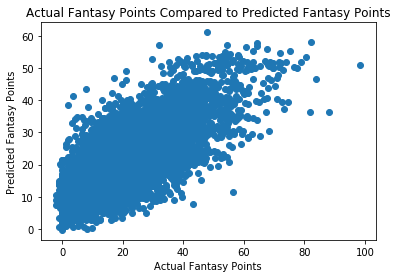

In [213]:
plt.scatter(y_test, lin_reg.predict(X_test_scale))
plt.xlabel('Actual Fantasy Points')
plt.ylabel('Predicted Fantasy Points')
plt.title("Actual Fantasy Points Compared to Predicted Fantasy Points")
plt.show()

#### Lasso Regression

In [214]:
lassocv = LassoCV()
lassocv.fit(X_train_scale, y_train)
lassocv_score = lassocv.score(X_test_scale, y_test)
lassocv_alpha = lassocv.alpha_
print('Intercept:', lassocv.intercept_)
print('Coefficients: \n', lassocv.coef_)
print('Variance score: %.5f' %lassocv_score)
print('Alpha:  %.2f' %lassocv.alpha_)

Intercept: 21.134235507246377
Coefficients: 
 [-0.20625139 -0.          0.14209927  0.78069775  0.20855041  0.73376936
  7.03271569  0.08794095  0.12991172  1.97167029  0.         -0.
  0.          0.27544664 -0.37840789]
Variance score: 0.54691
Alpha:  0.03


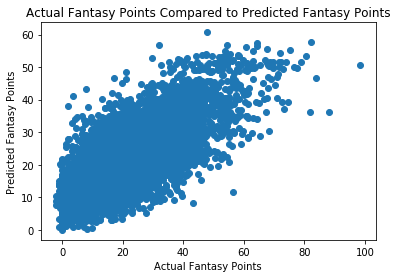

In [215]:
plt.scatter(y_test, lassocv.predict(X_test_scale))
plt.xlabel('Actual Fantasy Points')
plt.ylabel('Predicted Fantasy Points')
plt.title("Actual Fantasy Points Compared to Predicted Fantasy Points")
plt.show()

#### Ridge Regression

In [216]:
ridgecv = RidgeCV()
ridgecv.fit(X_train_scale, y_train)
ridgecv_score = ridgecv.score(X_test_scale, y_test)
print('Intercept:', ridgecv.intercept_)
print('Coefficients: \n', ridgecv.coef_)
print('Variance score: %.5f' % ridgecv_score)
print('Alpha:  %.2f' %ridgecv.alpha_)

Intercept: 21.134235507246377
Coefficients: 
 [-0.41259212  0.17814069  0.0206883   1.03038041  0.24083344  0.78160636
  7.0553025   0.10640775  0.1760077   2.15928213 -0.04341055 -0.35368309
 -0.0409516   0.31871181 -0.41089706]
Variance score: 0.54702
Alpha:  10.00


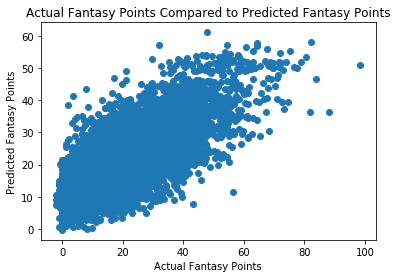

In [217]:
plt.scatter(y_test, ridgecv.predict(X_test_scale))
plt.xlabel('Actual Fantasy Points')
plt.ylabel('Predicted Fantasy Points')
plt.title("Actual Fantasy Points Compared to Predicted Fantasy Points")
plt.show()

#### KNN Regressor

#### Decision Tree Regressor

#### Random Forest Regressor

## Prediction

In [218]:
columns= ['Id', 'Nickname', 'Salary',  'Team', 'Opponent', 'Game', 'Injury Indicator']
fd = pd.read_csv(file, usecols=columns)

In [219]:
fd["Id"] = fd["Id"].str.split('-').str[1].astype(int)
fd = fd[fd['Injury Indicator'] != 'O']

In [220]:
fd['Opponent'] = np.where(fd['Opponent'] == "NY", "NYK", fd['Opponent'])
fd['Opponent'] = np.where(fd['Opponent'] == "NO", "NOP", fd['Opponent'])
fd['Opponent'] = np.where(fd['Opponent'] == "BKN", "BRK", fd['Opponent'])
fd['Opponent'] = np.where(fd['Opponent'] == "CHA", "CHO", fd['Opponent'])
fd['Opponent'] = np.where(fd['Opponent'] == "GS", "GSW", fd['Opponent'])
fd['Opponent'] = np.where(fd['Opponent'] == "SA", "SAS", fd['Opponent'])
fd['Team'] = np.where(fd['Team'] == "NY", "NYK", fd['Team'])
fd['Team'] = np.where(fd['Team'] == "NO", "NOP", fd['Team'])
fd['Team'] = np.where(fd['Team'] == "BKN", "BRK", fd['Team'])
fd['Team'] = np.where(fd['Team'] == "CHA", "CHO", fd['Team'])
fd['Team'] = np.where(fd['Team'] == "GS", "GSW", fd['Team'])
fd['Team'] = np.where(fd['Team'] == "SA", "SAS", fd['Team'])

#### Home/Away

In [221]:
home = fd['Game'].str.split("@", n = 1, expand = True)
fd['Away'] = home[0]
fd['Home'] = home[1]
fd['Home'] = np.where(fd['Home'] == "NY", "NYK", fd['Home'])
fd['Home'] = np.where(fd['Home'] == "NO", "NOP", fd['Home'])
fd['Home'] = np.where(fd['Home'] == "BKN", "BRK", fd['Home'])
fd['Home'] = np.where(fd['Home'] == "CHA", "CHO", fd['Home'])
fd['Home'] = np.where(fd['Home'] == "GS", "GSW", fd['Home'])
fd['Home'] = np.where(fd['Home'] == "SA", "SAS", fd['Home'])
fd['Away'] = np.where(fd['Away'] == "NY", "NYK", fd['Away'])
fd['Away'] = np.where(fd['Away'] == "NO", "NOP", fd['Away'])
fd['Away'] = np.where(fd['Away'] == "BKN", "BRK", fd['Away'])
fd['Away'] = np.where(fd['Away'] == "CHA", "CHO", fd['Away'])
fd['Away'] = np.where(fd['Away'] == "GS", "GSW", fd['Away'])
fd['Away'] = np.where(fd['Away'] == "SA", "SAS", fd['Away'])
fd['Home/Away'] = np.where(fd['Team'] == fd['Home'], 1, 0)
fd.drop(columns=['Game', 'Home', 'Away'], inplace=True)

In [222]:
fd.head(10)

,Id,Nickname,Salary,Team,Opponent,Injury Indicator,Home/Away
0,9644,James Harden,12600,HOU,MIL,NaN,1
1,15755,Anthony Davis,12500,NOP,CLE,NaN,1
2,40199,Giannis Antetokounmpo,11800,MIL,HOU,NaN,0
4,49111,Joel Embiid,10800,PHI,WAS,NaN,0
5,15595,Bradley Beal,10000,WAS,PHI,NaN,1
6,14514,Nikola Vucevic,9600,ORL,UTA,NaN,0
7,15557,Andre Drummond,9500,DET,LAL,NaN,0
8,55057,Jusuf Nurkic,9400,POR,CHI,NaN,1
9,66115,Ben Simmons,9300,PHI,WAS,NaN,0
10,9560,Blake Griffin,9200,DET,LAL,NaN,0


In [223]:
fd.shape

(288, 7)

In [224]:
latest = gamelogs.loc[gamelogs.groupby('Player').Date.idxmax()]
latest = latest.loc[:, ['Player', 'Date', 'Game_Num','Pos', 'GS','MP', 'FPTS', 'Age','Age_sq','PV_FPTS', 'PV_FPTS_2', 
                        'Home/Away', 'PV_GS','AVG_FPTS', 'Std_FPTS', 'AVG_MP','AVG_FPTS_2', 'Std_FPTS_2', 'AVG_MP_2', 
                        'AVG_FPTS_3', 'Std_FPTS_3', 'AVG_MP_3', 'POS_AVG_FPTS', 'Opp_AVG_FPTS', 'Rest', 'After_Injury','PV_MP',
                        'PV_MP_2']]
latest = latest[latest.Date > '2018-05-01']
latest.drop(columns=['Home/Away'],inplace=True)

In [225]:
latest[latest['Date']==latest['Date'].max()].head()

,Player,Date,Game_Num,Pos,GS,MP,FPTS,Age,Age_sq,PV_FPTS,...,AVG_MP_2,AVG_FPTS_3,Std_FPTS_3,AVG_MP_3,POS_AVG_FPTS,Opp_AVG_FPTS,Rest,After_Injury,PV_MP,PV_MP_2
37977,Abdel Nader,2019-01-08,21,F,0,9,0.2,25.287671,639.466316,12.0,...,14.0,9.833333,7.779674,14.000000,18.427160,20.627632,NaN,0,14.0,14.0
37980,Alec Burks,2019-01-08,37,G,1,30,32.4,27.471233,754.668636,22.6,...,33.0,20.266667,6.806859,31.000000,18.852469,18.666667,NaN,0,36.0,30.0
37983,Alex Len,2019-01-08,36,C,0,22,10.2,25.564384,653.537707,14.4,...,20.5,29.566667,15.405302,22.666667,24.002469,27.351667,NaN,0,20.0,21.0
37985,Alfonzo McKinnie,2019-01-08,32,F,0,16,10.0,26.309589,692.194476,3.2,...,6.5,5.833333,2.874601,9.000000,18.427160,21.286842,NaN,0,8.0,5.0
37988,Allonzo Trier,2019-01-08,34,G,0,29,18.6,22.975342,527.866361,2.2,...,11.0,6.166667,5.464735,13.666667,18.852469,17.928750,NaN,0,13.0,9.0


In [226]:
latest.columns

Index(['Player', 'Date', 'Game_Num', 'Pos', 'GS', 'MP', 'FPTS', 'Age',
       'Age_sq', 'PV_FPTS', 'PV_FPTS_2', 'PV_GS', 'AVG_FPTS', 'Std_FPTS',
       'AVG_MP', 'AVG_FPTS_2', 'Std_FPTS_2', 'AVG_MP_2', 'AVG_FPTS_3',
       'Std_FPTS_3', 'AVG_MP_3', 'POS_AVG_FPTS', 'Opp_AVG_FPTS', 'Rest',
       'After_Injury', 'PV_MP', 'PV_MP_2'],
      dtype='object')

In [227]:
latest.shape

(480, 27)

#### List of names that are close together

In [228]:
latest['Player'] = np.where(latest['Player'] == "Dennis Smith", "Dennis Smith Jr.", latest['Player'])
latest['Player'] = np.where(latest['Player'] == "Derrick Walton", "Derrick Walton Jr.", latest['Player'])
latest['Player'] = np.where(latest['Player'] == "Gary Payton", "Gary Payton II", latest['Player'])
latest['Player'] = np.where(latest['Player'] == "Glenn Robinson", "Glenn Robinson III", latest['Player'])
latest['Player'] = np.where(latest['Player'] == "James Ennis", "James Ennis III", latest['Player'])
latest['Player'] = np.where(latest['Player'] == "J.J. Redick", "JJ Redick", latest['Player'])
latest['Player'] = np.where(latest['Player'] == "J.R. Smith", "JR Smith", latest['Player'])
latest['Player'] = np.where(latest['Player'] == "Kelly Oubre", "Kelly Oubre Jr.", latest['Player'])
latest['Player'] = np.where(latest['Player'] == "Larry Nance", "Larry Nance Jr.", latest['Player'])
latest['Player'] = np.where(latest['Player'] == "Nene Hilario", "Nene", latest['Player'])
latest['Player'] = np.where(latest['Player'] == "Otto Porter", "Otto Porter Jr.", latest['Player'])
latest['Player'] = np.where(latest['Player'] == "Larry Nance", "Larry Nance Jr.", latest['Player'])
latest['Player'] = np.where(latest['Player'] == "P.J. Tucker", "PJ Tucker", latest['Player'])
latest['Player'] = np.where(latest['Player'] == 'Taurean Waller-Prince', 'Taurean Prince', latest['Player'])
latest['Player'] = np.where(latest['Player'] == 'Tim Hardaway', 'Tim Hardaway Jr.', latest['Player'])
latest['Player'] = np.where(latest['Player'] == "T.J. Leaf", "TJ Leaf", latest['Player'])
latest['Player'] = np.where(latest['Player'] == "T.J. Warren", "TJ Warren", latest['Player'])
latest['Player'] = np.where(latest['Player'] == "Wade Baldwin", "Wade Baldwin IV", latest['Player'])
latest['Player'] = np.where(latest['Player'] == "Wesley Iwundu", "Wes Iwundu", latest['Player'])

#### Merge

In [229]:
today = pd.merge(fd, latest, how='left', left_on='Nickname', right_on='Player')

In [230]:
today.shape

(288, 34)

### Variables for Prediction

#### Started Previous Game

In [231]:
today['PV_GS'] = today['GS']
today.drop(columns=['GS'], inplace=True)

#### Rest

In [232]:
today['Rest'] = (pd.to_datetime('today').date() - today['Date'].dt.date).dt.days - 1
today['Rest'] = np.where(today['Rest'] > 6, np.NaN, today['Rest'])
today['Rest'].fillna((today['Rest'].mean()), inplace=True)

#### Injury Status

In [233]:
today['After_Injury'] = np.where(today['Injury Indicator'] == 'GTD', 1, 0)
today.drop(columns=['Injury Indicator'], inplace=True)

#### Previous Game,  Last 2 Games, and Last 3 Games Stats (Average & Standard Deviation Fantasy Points, Average Minutes) 

In [234]:
today.drop(columns=['Std_FPTS_2', 'Std_FPTS_3'], inplace=True)

In [235]:
x = today.loc[:,['Player','FPTS','PV_FPTS']]
x['Std_FPTS_2'] = x.std(axis=1)
x.drop(columns=['FPTS','PV_FPTS'], inplace=True)
x.drop_duplicates(keep='first', inplace=True)
today = pd.merge(today, x, how='left', on='Player')

In [236]:
y = today.loc[:,['Player','FPTS','PV_FPTS', 'PV_FPTS_2']]
y['Std_FPTS_3'] = y.std(axis=1)
y.drop(columns=['FPTS','PV_FPTS', 'PV_FPTS_2'], inplace=True)
y.drop_duplicates(keep='first', inplace=True)
today = pd.merge(today, y, how='left', on='Player')

In [237]:
today['AVG_FPTS_3'] = (today['FPTS'] + today['PV_FPTS'] + today['PV_FPTS_2'])/3
today['AVG_FPTS_2'] = (today['FPTS'] + today['PV_FPTS'])/2
today['PV_FPTS'] = today['FPTS']
today.drop(columns=['FPTS'], inplace=True)

In [238]:
today['AVG_MP_3'] = (today['MP'] + today['PV_MP'] + today['PV_MP_2'])/3
today['AVG_MP_2'] = (today['MP'] + today['PV_MP'])/2
today['PV_MP'] = today['MP']
today.drop(columns=['MP'], inplace=True)

#### Position Average

In [239]:
Pos_avg = gamelogs.loc[:,['Pos','Date', 'POS_AVG_FPTS']]
Pos_avg = Pos_avg[Pos_avg['Date']==Pos_avg['Date'].max()]
Pos_avg.drop(columns=['Date'], inplace=True)
Pos_avg.drop_duplicates(keep='first', inplace=True)

In [240]:
today.drop(columns=['POS_AVG_FPTS'], inplace=True)
today_x = pd.merge(today, Pos_avg, how='left', on=['Pos'])
today = today_x

#### Opponent Average by Position

In [241]:
Opp_avg = gamelogs.loc[:,['Pos','Opp','Date', 'Opp_AVG_FPTS']]
Opp_avg.sort_values(by=['Opp', 'Date'], ascending=False, inplace=True)
Opp_avg.drop(columns=['Date'], inplace=True)
Opp_avg.drop_duplicates(subset=['Pos','Opp'], keep='first', inplace=True)

In [242]:
Opp_avg.shape

(220, 3)

In [243]:
today.drop(columns=['Opp_AVG_FPTS'], inplace=True)
today_y = pd.merge(today, Opp_avg, how='left', left_on=['Pos','Opponent'], right_on=['Pos', 'Opp'])
today = today_y

#### Validation

In [244]:
today.columns

Index(['Id', 'Nickname', 'Salary', 'Team', 'Opponent', 'Home/Away', 'Player',
       'Date', 'Game_Num', 'Pos', 'Age', 'Age_sq', 'PV_FPTS', 'PV_FPTS_2',
       'PV_GS', 'AVG_FPTS', 'Std_FPTS', 'AVG_MP', 'AVG_FPTS_2', 'AVG_MP_2',
       'AVG_FPTS_3', 'AVG_MP_3', 'Rest', 'After_Injury', 'PV_MP', 'PV_MP_2',
       'Std_FPTS_2', 'Std_FPTS_3', 'POS_AVG_FPTS', 'Opp', 'Opp_AVG_FPTS'],
      dtype='object')

In [245]:
today = today.reindex(columns=['Player','Age', 'Age_sq','PV_FPTS', 'PV_MP','Home/Away',
                         'PV_GS', 'AVG_FPTS', 'Std_FPTS', 'Std_FPTS_2',
                         'AVG_FPTS_3', 'Std_FPTS_3', 'AVG_MP_3', 'POS_AVG_FPTS', 'Opp_AVG_FPTS',  'After_Injury'])

# 'PV_FPTS_2', 'PV_MP_2', 'AVG_FPTS_2', 'AVG_MP_2','Rest','AVG_MP',

In [246]:
today = today.dropna()

In [247]:
today.isnull().sum(axis=0)

Player          0
Age             0
Age_sq          0
PV_FPTS         0
PV_MP           0
Home/Away       0
PV_GS           0
AVG_FPTS        0
Std_FPTS        0
Std_FPTS_2      0
AVG_FPTS_3      0
Std_FPTS_3      0
AVG_MP_3        0
POS_AVG_FPTS    0
Opp_AVG_FPTS    0
After_Injury    0
dtype: int64

In [248]:
today.shape

(260, 16)

In [249]:
today.columns

Index(['Player', 'Age', 'Age_sq', 'PV_FPTS', 'PV_MP', 'Home/Away', 'PV_GS',
       'AVG_FPTS', 'Std_FPTS', 'Std_FPTS_2', 'AVG_FPTS_3', 'Std_FPTS_3',
       'AVG_MP_3', 'POS_AVG_FPTS', 'Opp_AVG_FPTS', 'After_Injury'],
      dtype='object')

In [250]:
print(lin_reg.predict(today.iloc[:,1:16]).sum(),'\n',lassocv.predict(today.iloc[:,1:16]).sum(),'\n', 
      ridgecv.predict(today.iloc[:,1:16]).sum())

89892.60544381847 
 53119.452584137754 
 85177.74932951941


In [271]:
today['Prediction'] = lin_reg.predict(today.iloc[:,1:16])

today['real_prediction'] = y_scaler.transform(today['Prediction'].values.reshape(-1,1))

In [272]:
today.head()

,Player,Age,Age_sq,PV_FPTS,PV_MP,Home/Away,PV_GS,AVG_FPTS,Std_FPTS,Std_FPTS_2,AVG_FPTS_3,Std_FPTS_3,AVG_MP_3,POS_AVG_FPTS,Opp_AVG_FPTS,After_Injury,Prediction,real_prediction
0,James Harden,29.367123,862.427930,59.0,40.0,1,1.0,56.011765,13.794416,3.889087,64.333333,14.268263,40.333333,18.852469,19.082432,0,754.575086,52.700644
1,Anthony Davis,25.827397,667.054449,69.1,35.0,1,1.0,61.609091,12.223015,11.030866,68.266667,14.368136,35.333333,21.317284,18.871053,0,762.001404,53.234255
2,Giannis Antetokounmpo,24.087671,580.215905,53.0,35.0,0,1.0,55.960000,12.854713,10.323759,56.733333,9.563124,31.333333,26.052564,24.768182,0,683.022182,47.559283
3,Joel Embiid,24.816438,615.855613,38.0,24.0,0,1.0,52.736111,12.735107,9.121677,55.500000,20.196782,31.666667,24.002469,29.517241,0,653.693083,45.451871
4,Bradley Beal,25.531507,651.857842,38.6,31.0,1,1.0,40.358974,10.188841,7.353911,45.633333,6.092892,36.000000,18.852469,17.071795,0,554.162437,38.300198


In [273]:
today['real_prediction'].describe()

count    260.000000
mean      23.324273
std        8.911211
min        7.712658
25%       16.587904
50%       22.462776
75%       29.064150
max       53.234255
Name: real_prediction, dtype: float64

In [274]:
today[today['Player']=='Jrue Holiday']

,Player,Age,Age_sq,PV_FPTS,PV_MP,Home/Away,PV_GS,AVG_FPTS,Std_FPTS,Std_FPTS_2,AVG_FPTS_3,Std_FPTS_3,AVG_MP_3,POS_AVG_FPTS,Opp_AVG_FPTS,After_Injury,Prediction,real_prediction
12,Jrue Holiday,28.572603,816.393627,37.8,33.0,1,1.0,42.227027,7.163241,2.616295,36.7,5.434151,32.333333,18.852469,20.28375,0,583.623317,40.417079


In [275]:
today[today['PV_FPTS']==0]

,Player,Age,Age_sq,PV_FPTS,PV_MP,Home/Away,PV_GS,AVG_FPTS,Std_FPTS,Std_FPTS_2,AVG_FPTS_3,Std_FPTS_3,AVG_MP_3,POS_AVG_FPTS,Opp_AVG_FPTS,After_Injury,Prediction,real_prediction
126,Caleb Swanigan,21.698630,470.830550,0.0,2.0,1,0.0,6.200000,7.237828,0.141421,0.566667,0.814453,3.666667,18.427160,18.956757,0,159.752722,9.960290
178,Cheick Diallo,22.317808,498.084564,0.0,3.0,1,0.0,9.985185,8.331991,5.374012,6.133333,5.547372,9.000000,18.427160,19.302500,0,203.857239,13.129375
179,Ryan Anderson,30.580822,935.186669,0.0,5.0,0,0.0,9.200000,6.187891,0.141421,2.500000,4.158125,11.000000,18.427160,19.534211,0,276.147521,18.323719
182,Wesley Johnson,31.468493,990.266061,0.0,3.0,1,0.0,9.609091,6.562876,0.000000,2.066667,3.579572,6.333333,26.052564,30.611765,0,292.070762,19.467868
190,Naz Mitrou-Long,25.430137,646.691867,0.0,1.0,1,0.0,1.250000,1.767767,1.767767,0.833333,1.443376,4.666667,18.852469,18.539189,0,157.739316,9.815619
191,Georges Niang,25.558904,653.257579,0.0,1.0,1,0.0,5.336000,5.121758,0.848528,2.466667,3.288363,4.666667,18.427160,18.881081,0,191.661886,12.253090
197,PJ Dozier,22.194521,492.596742,0.0,2.0,1,0.0,5.900000,8.343860,0.000000,3.933333,6.812733,3.333333,18.852469,18.666667,0,168.968521,10.622482
201,Guerschon Yabusele,23.057534,531.649886,0.0,4.0,1,0.0,5.045000,4.699997,0.000000,2.566667,4.445597,5.666667,18.427160,18.978947,0,168.634792,10.598502
203,Brandon Knight,27.098630,734.335755,0.0,6.0,1,0.0,4.144444,3.801681,4.949747,6.000000,5.567764,10.333333,18.852469,19.082432,0,210.404680,13.599835
218,Chimezie Metu,21.764384,473.688392,0.0,1.0,0,0.0,6.041176,5.518385,5.374012,3.866667,3.801754,4.333333,18.427160,18.317105,0,165.200189,10.351712


In [276]:
corr_1 = today.corr()
corr_1.style.background_gradient().set_precision(2)

,Age,Age_sq,PV_FPTS,PV_MP,Home/Away,PV_GS,AVG_FPTS,Std_FPTS,Std_FPTS_2,AVG_FPTS_3,Std_FPTS_3,AVG_MP_3,POS_AVG_FPTS,Opp_AVG_FPTS,After_Injury,Prediction,real_prediction
Age,1,0.99,0.0079,0.058,0.079,-0.036,0.082,0.046,-0.047,0.041,0.0063,0.11,0.084,0.12,-0.009,0.45,0.45
Age_sq,0.99,1,-0.0051,0.044,0.074,-0.045,0.063,0.03,-0.048,0.024,0.00075,0.088,0.078,0.12,-0.008,0.44,0.44
PV_FPTS,0.0079,-0.0051,1,0.83,0.0098,0.62,0.73,0.53,0.28,0.87,0.35,0.74,0.22,0.16,-0.08,0.72,0.72
PV_MP,0.058,0.044,0.83,1,0.031,0.73,0.68,0.52,0.21,0.78,0.27,0.9,0.15,0.11,-0.043,0.7,0.7
Home/Away,0.079,0.074,0.0098,0.031,1,0.008,0.013,-0.0047,0.056,0.044,0.029,0.044,0.042,0.067,0.068,0.05,0.05
PV_GS,-0.036,-0.045,0.62,0.73,0.008,1,0.7,0.49,0.089,0.69,0.16,0.78,0.2,0.11,-0.0079,0.64,0.64
AVG_FPTS,0.082,0.063,0.73,0.68,0.013,0.7,1,0.74,0.19,0.89,0.32,0.79,0.27,0.17,0.04,0.91,0.91
Std_FPTS,0.046,0.03,0.53,0.52,-0.0047,0.49,0.74,1,0.28,0.67,0.45,0.64,0.24,0.22,0.0032,0.67,0.67
Std_FPTS_2,-0.047,-0.048,0.28,0.21,0.056,0.089,0.19,0.28,1,0.24,0.69,0.19,0.05,0.066,0.034,0.18,0.18
AVG_FPTS_3,0.041,0.024,0.87,0.78,0.044,0.69,0.89,0.67,0.24,1,0.39,0.85,0.27,0.18,-0.026,0.86,0.86


## Generate Lineup

#### Data in Right Format

In [277]:
opt = today.loc[:,['Player', 'real_prediction']]

In [278]:
fd_opt = pd.read_csv(file)

In [279]:
fd_opt = pd.merge(fd_opt, today, how='left', left_on='Nickname', right_on='Player')
fd_opt['FPPG'] = fd_opt['real_prediction'].astype(str)

In [280]:
fd_opt = fd_opt[fd_opt['Nickname']!='Carmelo Anthony']

In [281]:
fd_opt.drop_duplicates(subset=['Player','real_prediction'], keep=False, inplace=True)

In [282]:
fd_opt.drop(columns=['Player', 'real_prediction'],inplace=True)

In [283]:
fd_opt.shape

(259, 30)

In [284]:
fd_opt.to_csv("lineup.csv")

#### Set Lineup

In [285]:
optimizer = get_optimizer(Site.FANDUEL, Sport.BASKETBALL)

In [286]:
optimizer.load_players_from_CSV("lineup.csv")

In [267]:
# Barea GTD
#barea = optimizer.get_player_by_name('J.J. Barea')
#barea.max_exposure = 0.0

# Jamal Crawford
#korver = optimizer.get_player_by_name('Jamal Crawford')
#korver.max_exposure = 0.0

# Parker
#parker = optimizer.get_player_by_name('Rudy Gay')
#parker.max_exposure = 0.0

# Dirk GTD
#dirk = optimizer.get_player_by_name('Dirk Nowitzki')
#dirk.max_exposure = 0.0

# Pau
#pau = optimizer.get_player_by_name('Pau Gasol')
#pau.max_exposure = 0.0

# Millsap
#millsap = optimizer.get_player_by_name('Millsap')
#millsap.max_exposure = 0.0

In [287]:
k = 5
exposure = k/k
random = False

for lineup in optimizer.optimize(n=k, max_exposure = exposure, randomness=random):
    print(lineup)

 1. PG    J.J. Barea                    PG    DAL            31.607  4400.0$   
 2. PG    Mike Conley                   PG    MEM            40.392  8400.0$   
 3. SG    James Harden                  SG    HOU            52.701  12600.0$  
 4. SG    Jamal Crawford                SG    PHO            31.256  3700.0$   
 5. SF    Vince Carter                  SF    ATL            34.783  3500.0$   
 6. SF    Trevor Ariza                  SF    WAS            35.001  6400.0$   
 7. PF    LaMarcus Aldridge             PF    SA             41.496  7900.0$   
 8. PF    Blake Griffin                 PF    DET            45.121  9200.0$   
 9. C     Pau Gasol                     C     SA             34.098  3900.0$   

Fantasy Points 346.455
Salary 60000.0
 1. PG    J.J. Barea                    PG    DAL            31.607  4400.0$   
 2. PG    Kyrie Irving                  PG    BOS            39.762  8400.0$   
 3. SG    James Harden                  SG    HOU            52.701  12600.0$  
 